In [1]:
import os
import shutil
import pandas as pd
pd.set_option('display.max_colwidth', None)
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install geopy
from geopy.geocoders import Nominatim
loc = Nominatim(user_agent="GetLoc")

In [3]:
from google.cloud import storage

In [4]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
filtered=spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/sirivanth/new_filtered')

23/03/10 20:16:27 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [13]:
filtered.createOrReplaceTempView("filtered")

In [14]:
query = '''
select created_at, coordinates.coordinates as coordi,
user.screen_name as Profile,
user.description as Description,
user.location as user_location,
user.verified as is_verified
from filtered'''
a = spark.sql(query)

In [15]:
a.createOrReplaceTempView("filtered")

In [9]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

key,value
spark.sql.legacy....,LEGACY


In [10]:
b = a.select(col("user_location"),col("created_at"),to_date(col("created_at"),'EEE MMM d HH:mm:ss z yyyy').alias("date"))

In [11]:
b.createOrReplaceTempView("filtered")

In [18]:
spark.sql("""
SELECT Description, Profile, cnt
FROM (
    SELECT Description, Profile, COUNT(*) AS cnt
    FROM filtered
    WHERE Description IS NOT NULL
    GROUP BY Description, Profile
) subquery
ORDER BY cnt DESC
LIMIT 10
""").toPandas()


,Description,Profile,cnt
0,All education content. Education changes the life.\nSoftware Developer| ML | DS | Technical Blogging at http://techmorf.com |,education_24x7,6316
1,I AM The Documentary,EssayPaperUK,6264
2,🎧🍦🍥🪐☕\nPost Every Love Live! Nijigaku!!. 1 Frame each 5 minutes \nJoin us on Discord \nhttp://discord.com/invite/5T6cXH4…,LoveLiveFrames,5774
3,National Preps director of South East Scouting 706-615-2824 Athletes add yourself to the National Preps database https://tinyurl.com/2p89y6ub,jwindon35,5167
4,"One Stop Platform on #Education. Follow Us to know the latest in Indian & Global Education , research, books, literature, academics and education sector news",indiaedudiary,4804
5,THIS WEBSITE PROVIDE LATEST NEWS ON EDUCATION. Continue To help US FOR LATEST NEWS AND WE WILL PROVIDE BEST OF OUR EFFORTS TO MAKE YOU UPDATED,group_kq,4541
6,hs game update news,AndrianyRahmah,4541
7,Data Quality Professional. Member of the @K12Prospects Data Quality team. Delivering the most accurate data of all schools and districts nationwide.,jc_james_clark,3558
8,Dog 🐶 lover PLL #1 tv show Chicago series #1 TV series franchise Zumba fitness and Fit barre,sarah052794,3143
9,"Welcom TV listing for all\nEnjoy your watching live sports - Football,Basketball and more (Click the link below the description)",sport9920,2653


In [14]:
spark.sql("select date, user_location, count(*) from filtered where user_location is not null group by date, user_location order by count(*) desc limit 10").toPandas()

KeyboardInterrupt: 

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession

df = spark.sql("select date, user_location, count(*) from filtered where user_location is not null group by date, user_location order by count(*) desc limit 5000").toPandas()

In [13]:
!pip install geocoder

In [18]:
%%time
import geocoder
import pandas as pd
import time

# define a function to geocode locations in batches

def geocode_batch(locations):
    # geocode the locations in batches
    batch_size = 100
    results = []
    for i in range(0, len(locations), batch_size):
        batch = locations[i:i+batch_size]
        batch_str = ','.join([''] if x is None else x for x in batch)
        # geocode the batch
        g = geocoder.osm(batch_str, timeout=10)
        if g.ok:
            results.extend(g)
        # sleep to avoid hitting rate limits
        time.sleep(1)
    return results


# define a function to get country from location
def get_country(location, cache):
    # check if the country is in the cache
    if location in cache:
        return cache[location]
    
    # otherwise, geocode the location
    g = geocoder.osm(location, timeout=10)
    if g.ok:
        # cache the result
        cache[location] = g.country
        return g.country
    else:
        return None

# initialize a cache
cache = {}

# extract the locations from the Pandas DataFrame as a list
locations = df['user_location'].tolist()

# geocode the locations in batches
results = geocode_batch(locations)

# map the results to a dictionary
location_dict = {}
for result in results:
    if result is not None:
        location_dict[result['query']] = result['country']

# add a new 'country' column to the dataframe
df['country'] = df['user_location'].apply(lambda location: get_country(location, cache))

CPU times: user 2.3 s, sys: 118 ms, total: 2.41 s
Wall time: 1min 53s


In [19]:
df

,date,user_location,count(1),country
0,2022-06-06,"Kolkata, India",4737,India
1,2022-08-25,United States,4030,United States
2,2022-06-05,"Kolkata, India",3267,India
3,2022-08-24,United States,3116,United States
4,2022-08-26,United States,3004,United States
...,...,...,...,...
4995,2022-06-05,Kolkata,280,India
4996,2023-02-06,"Chicago, IL",280,United States
4997,2022-11-15,United Kingdom,280,United Kingdom
4998,2023-01-20,Canada,280,Canada


In [20]:
df

,date,user_location,count(1),country
0,2022-06-06,"Kolkata, India",4737,India
1,2022-08-25,United States,4030,United States
2,2022-06-05,"Kolkata, India",3267,India
3,2022-08-24,United States,3116,United States
4,2022-08-26,United States,3004,United States
...,...,...,...,...
4995,2022-06-05,Kolkata,280,India
4996,2023-02-06,"Chicago, IL",280,United States
4997,2022-11-15,United Kingdom,280,United Kingdom
4998,2023-01-20,Canada,280,Canada


In [21]:
df1= df.groupby('country').sum('count(1)').sort_values('count(1)', ascending = False)

In [22]:
df1.reset_index(inplace=True)
df1

,country,count(1)
0,United States,1514122
1,Nigeria,431609
2,India,206892
3,United Kingdom,109658
4,Canada,66945
5,Kenya,63623
6,السعودية,21564
7,پاکستان,19395
8,South Africa,13555
9,Uganda,7040


/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3611 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3619 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3632 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3607 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: Runti

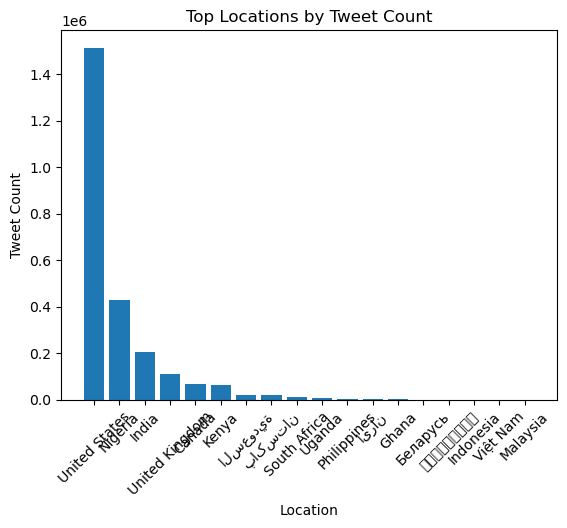

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession

# Create bar graph
plt.bar(df1['country'],df1['count(1)'])
plt.xticks(rotation=45)
plt.title('Top Locations by Tweet Count')
plt.xlabel('Location')
plt.ylabel('Tweet Count')
plt.show()

In [24]:
!pip install plotly

In [26]:
df1.to_csv('gs://msca-bdp-students-bucket/shared_data/sirivanth/location.csv')

In [ ]:
import plotly.express as px

fig = px.choropleth(df1, locations='country', locationmode='country names', color='count(1)', 
                    title='Top Locations by Tweet Count', color_continuous_scale='Blues',
                    labels={'count(1)': 'Tweet Count'})

fig.show()


In [27]:
a.createOrReplaceTempView("filtered")

In [28]:
geo = spark.sql('select user_location,count(*) from filtered group by user_location order by count(*) desc limit 200').toPandas()

In [29]:
geo['country'] = ''
for i in range(len(geo)):
    if geo['user_location'][i] != None:
        getLoc = loc.geocode(geo['user_location'][i])
        if getLoc != None:
            geo['country'][i] = getLoc.address.split(',')[-1]

/tmp/ipykernel_17818/1693243189.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
for i in range(0,len(geo)):
    geo['country'][i] = geo['country'][i].lstrip()

/tmp/ipykernel_17818/1520803162.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
df = geo.groupby(['country']).sum()

In [32]:
df.reset_index(inplace=True)

In [33]:
df.drop([0],inplace=True)

In [34]:
df['country_latitude'] = 0.0
df['country_longitude'] = 0.0
for i in range(1,len(df)):
    if df['country'][i] != None:
        getLoc = loc.geocode(df['country'][i])
        if getLoc != None:
            df['country_latitude'][i] = getLoc.latitude
            df['country_longitude'][i] = getLoc.longitude

/tmp/ipykernel_17818/308642908.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_17818/308642908.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [36]:
!pip install contextily

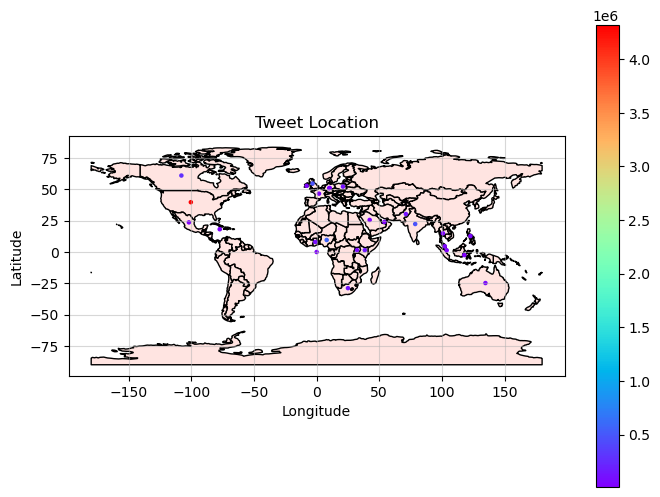

In [38]:
import geopandas as gpd
import matplotlib.pyplot as plt

# read in a map dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# read in your data and convert it to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.country_longitude, df.country_latitude))

# create a figure and axis object
fig, ax = plt.subplots(figsize=(8,6))

# plot the map on the axis
world.plot(ax=ax, color='mistyrose', edgecolor='black')

# plot the data points on the map
gdf.plot(column='count(1)', cmap='rainbow', markersize=5, legend=True, ax=ax)

# add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Tweet Location')

# add grid
ax.grid(b=True, alpha=0.5)

# show the plot
plt.show()
